# Pytorch 6. 使用GPU训练 (Training with GPU)

下面的代码演示了如何使用GPU训练模型。我的电脑没有GPU，所以以下代码都是在云端运行的。

在导入所有库后，输入`torch.cuda.is_available()` 查看GPU是否可用。

In [1]:
import os
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
import matplotlib.pyplot as plt


torch.cuda.is_available()


True

我们也可以使用下面的代码查看 GPU 的硬件信息。

In [2]:
!nvidia-smi

Tue Feb  1 01:25:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla M60           On   | 00000001:00:00.0 Off |                  Off |
| N/A   35C    P0    39W / 150W |    613MiB /  8129MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

我们希望通过 GPU 训练模型，这意味着出来模型会被储存到 GPU 外 数据也会被储存到 GPU 。

为此，我们可以执行下面的代码：

In [3]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

然而，我们经常希望编写允许各种人使用我们的代码的代码，包括那些可能没有可用 GPU 的人。为了解决这个问题，我们可以使用上面的 torch.cuda.is_available() 并执行以下操作：

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


如果想要查看 GPU 的数量，也很简单，使用下面的代码即可：

In [5]:
torch.cuda.device_count()

1

这里我只有一块 GPU，但在大型的项目中，我们可能有多块 GPU，因此可以将模型的不同层放在不同的 GPU 上。但对于一般的小型项目来说，一块 GPU 就够了。

下面我们将之前编写好的神经网络和数据集的类复制过来：

In [6]:
REBUILD_DATA = True # set to true to one once, then back to false unless you want to change something in your training data.

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    TESTING = "PetImages/Testing"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []

    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])  # do something like print(np.eye(2)[1]), just makes one_hot 
                        #print(np.eye(2)[self.LABELS[label]])

                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1

                    except Exception as e:
                        pass
                        #print(label, f, str(e))

        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print('Cats:',dogsvcats.catcount)
        print('Dogs:',dogsvcats.dogcount)


class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 2) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)

下面，我们要将模型分配到可用的 GPU 上。这个操作非常简单。只需要 `net.to(device`即可。或者根据之前的代码，可以写成: 

In [7]:

net = Net().to(device)
print(net)


Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


下面开始构建数据集：

In [8]:
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

training_data = np.load("training_data.npy", allow_pickle=True)
print(len(training_data))

X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

PetImages/Cat


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12501/12501 [09:44<00:00, 21.39it/s]


PetImages/Dog


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12501/12501 [11:06<00:00, 18.75it/s]


Cats: 12476
Dogs: 12470
24946


<ipython-input-8-cbdf08dc9c4d>:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180595841/work/torch/csrc/utils/tensor_new.cpp:201.)
  X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)


下面创建反向传播的函数：

In [9]:
def train(net):
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    loss_function = nn.MSELoss()
    BATCH_SIZE = 100
    EPOCHS = 5
    for epoch in range(EPOCHS):
        for i in range(0, len(train_X), BATCH_SIZE): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
            #print(f"{i}:{i+BATCH_SIZE}")
            batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
            batch_y = train_y[i:i+BATCH_SIZE]
            
            # Send batch data to GPU 
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            net.zero_grad()

            optimizer.zero_grad()   # zero the gradient buffers
            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()    # Does the update

        print(f"Epoch: {epoch}. Loss: {loss}")

train(net)

Epoch: 0. Loss: 0.2506680488586426
Epoch: 1. Loss: 0.2084140181541443
Epoch: 2. Loss: 0.1876126527786255
Epoch: 3. Loss: 0.15635128319263458
Epoch: 4. Loss: 0.13466419279575348


这里我们怕跑五个 `epoch` 的训练时间是 `30.5s` 相比之前在 CPU 上每个 `epoch` 都要花费 `1min`以上真的要快很多。下面我们将测试函数也用 GPU 跑一下：

In [10]:
test_X.to(device)
test_y.to(device)

def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1, 1, 50, 50).to(device))[0]  # returns a list, 
            predicted_class = torch.argmax(net_out)

            if predicted_class == real_class:
                correct += 1
            total += 1

    print("Accuracy: ", round(correct/total, 3))

test(net)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2494/2494 [00:02<00:00, 1024.58it/s]

Accuracy:  0.71


这里的测试精度是 0.71，与之前在 CPU 上训练的结果差不多。但每个 `epoch` 的损失函数都会有所下降，这个看起来还算可以接受的，也许再多用几个 `epoch` 精度会更高一些。

那么，依然和以前一样，随便抓两张图片看下结果：

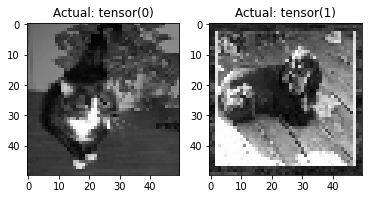

tensor(1, device='cuda:0')
tensor(1, device='cuda:0')


In [13]:
# randomly select a few images from the test set and plot them
plt.subplot(1,2,1)
plt.imshow(test_X[5], cmap="gray")
plt.title("Actual: " + str(test_y[5].argmax()))

plt.subplot(1,2,2)
plt.imshow(test_X[2], cmap="gray")
plt.title("Actual: " + str(test_y[2].argmax()))

plt.show()

print(torch.argmax(net(test_X[5].view(-1, 1, 50, 50).to(device))[0]))
print(torch.argmax(net(test_X[2].view(-1, 1, 50, 50).to(device))[0]))

# cat = tensor(0) dog = tensor(1).

这里很尴尬啊，两张图片里就有一个是错的。

此外，需要注意的一点是。在 GPU 上训练和在 CPU 上训练的数据结构是不一样的。对于 CPU 来说，我们的数据集是一个 `torch.Tensor`，而对于 GPU 来说，我们的数据集是一个 `torch.cuda.Tensor`。